# Result

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

%matplotlib inline

In [2]:
from methods.evaluation import Evaluation

In [4]:
domains = ['eclipse', 'netbeans', 'openoffice']
methods = ['baseline', 'baseline_dwen', 'propose', 'propose_softmax', 'propose_master_triplet_loss', 
               'propose_bert', 'doc2vec', 'fasttext']
authors = { 'baseline': 'Deshmukh et al. (2017)', 
            'baseline_dwen': 'Budhiraja et al. (2018)',
            'propose': 'P-Contextual',
           'propose_softmax': 'P-Softmax', 
           'propose_master_triplet_loss': 'Proposta',
           'propose_bert' : 'P-Siamese-Bert',
            'doc2vec': 'Doc2vec',
           'fasttext': 'FastText'
          }

### Retrieval 

In [5]:
recall = []
aproach, recall_index, datasets = [], [], []
df = pd.DataFrame(columns=['method', 'acc', 'recall@k', 'domain'])

for domain in domains:
    # Domain to use
    DOMAIN = domain
    # Dataset paths
    DIR = 'data/processed/{}'.format(DOMAIN)

    for method in methods:
        evaluation = Evaluation(0)
        path = os.path.join(DIR, 'exported_rank_{}.txt'.format(method))
        try:
            report = evaluation.evaluate(path)
            recall.append(report['1 - recall_at_5'])
            recall.append(report['2 - recall_at_10'])
            recall.append(report['3 - recall_at_15'])
            recall.append(report['4 - recall_at_20'])
            recall.append(report['5 - recall_at_25'])
            aproach += [authors[method]] * 5
            datasets += [domain] * 5
            recall_index += [5, 10, 15, 20, 25]
            print(path)
        except Exception as e:
            print(e)
            print("Does not exist result for: {}".format(path))
            pass

df['acc'] = recall
df['recall@k'] = recall_index
df['method'] = aproach
df['domain'] = datasets

data/processed/eclipse/exported_rank_baseline.txt
data/processed/eclipse/exported_rank_baseline_dwen.txt
data/processed/eclipse/exported_rank_propose.txt
data/processed/eclipse/exported_rank_propose_softmax.txt
data/processed/eclipse/exported_rank_propose_master_triplet_loss.txt
data/processed/eclipse/exported_rank_propose_bert.txt
data/processed/eclipse/exported_rank_doc2vec.txt
data/processed/eclipse/exported_rank_fasttext.txt
data/processed/netbeans/exported_rank_baseline.txt
data/processed/netbeans/exported_rank_baseline_dwen.txt
data/processed/netbeans/exported_rank_propose.txt
data/processed/netbeans/exported_rank_propose_softmax.txt
data/processed/netbeans/exported_rank_propose_master_triplet_loss.txt
[Errno 2] No such file or directory: 'data/processed/netbeans/exported_rank_propose_bert.txt'
Does not exist result for: data/processed/netbeans/exported_rank_propose_bert.txt
data/processed/netbeans/exported_rank_doc2vec.txt
data/processed/netbeans/exported_rank_fasttext.txt
data/

In [6]:
df[df['method'].isin([authors['baseline'], authors['propose_master_triplet_loss']])]

,method,acc,recall@k,domain
0,Deshmukh et al. (2017),0.36,5,eclipse
1,Deshmukh et al. (2017),0.43,10,eclipse
2,Deshmukh et al. (2017),0.48,15,eclipse
3,Deshmukh et al. (2017),0.51,20,eclipse
4,Deshmukh et al. (2017),0.54,25,eclipse
20,Proposta,0.36,5,eclipse
21,Proposta,0.44,10,eclipse
22,Proposta,0.49,15,eclipse
23,Proposta,0.52,20,eclipse
24,Proposta,0.55,25,eclipse


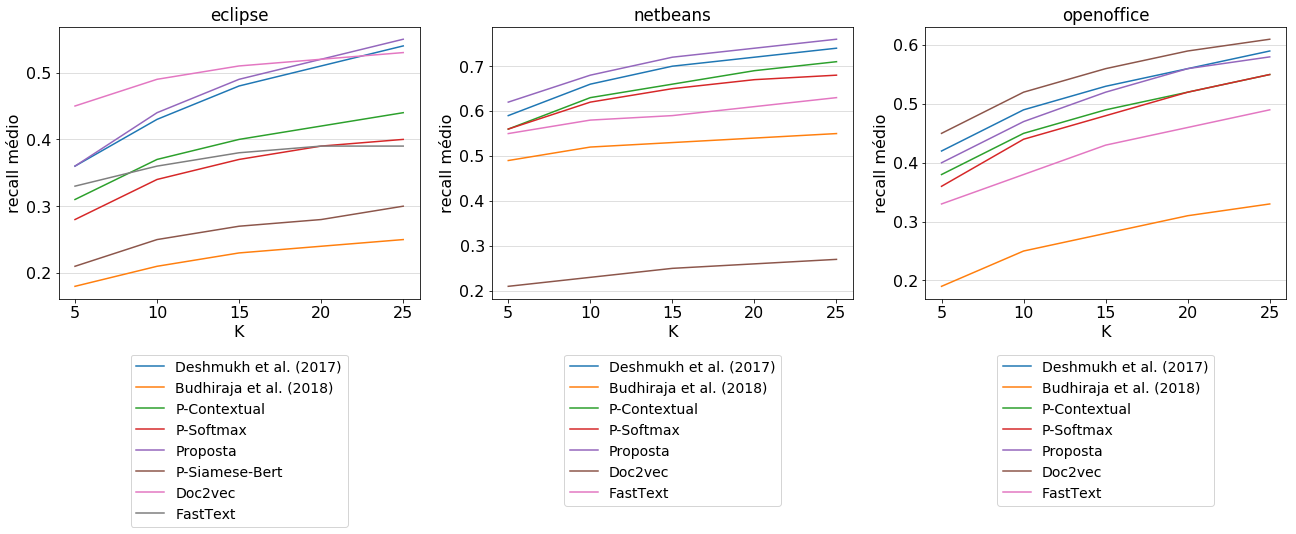

In [7]:
import matplotlib.ticker as mticker

MEDIUM_SIZE = 16
SMALL_SIZE = 14

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels

#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# equivalent but more general
fig, axes = plt.subplots(nrows=1, ncols=len(domains), figsize=(22, 5))

for index, domain in enumerate(domains):
    aproachs = df['method'].unique()
    for method in aproachs:
        experiment = df[(df['method'] == method) & (df['domain'] == domain)]
        if experiment.shape[0] > 0:
            experiment.plot(x='recall@k', y='acc', label=method, ax=axes[index])
    
    axes[index].set_ylabel('recall médio')
    axes[index].set_xlabel('K')
    text = axes[index].set_title('{}'.format(domain))
    lgd = axes[index].legend(loc='upper center', bbox_to_anchor=(0.5, -0.18))
    formatter = mticker.ScalarFormatter()
    axes[index].xaxis.set_major_formatter(formatter)
    axes[index].xaxis.set_major_locator(mticker.FixedLocator([5, 10, 15, 20, 25]))
    axes[index].grid(True, axis='y', alpha=.5)

fig.savefig('retrieval.png', bbox_inches="tight")

### Classification

In [8]:
import _pickle as pickle

rows = []

for domain in domains:
    # Dataset paths
    DIR = 'data/processed/{}'.format(domain)
    
    for method in methods:
        path = os.path.join(DIR, 'classification_{}.pkl'.format(method))

        try:
            with open(path, 'rb') as f:
                result = pickle.load(f)

            print(path)

            rows.append({ 'autor': authors[result['method']], 'acurácia' : result['acc_test'], 'roc/auc' : result['roc_test'],  
                         'domain' : domain })
        except:
            print("Does not exist result for: {}".format(path))
            pass
    
df_cls = pd.DataFrame(data=rows, columns=['autor', 'acurácia', 'roc/auc', 'domain'])

data/processed/eclipse/classification_baseline.pkl
data/processed/eclipse/classification_baseline_dwen.pkl
data/processed/eclipse/classification_propose.pkl
data/processed/eclipse/classification_propose_softmax.pkl
data/processed/eclipse/classification_propose_master_triplet_loss.pkl
Does not exist result for: data/processed/eclipse/classification_propose_bert.pkl
data/processed/eclipse/classification_doc2vec.pkl
data/processed/eclipse/classification_fasttext.pkl
data/processed/netbeans/classification_baseline.pkl
data/processed/netbeans/classification_baseline_dwen.pkl
data/processed/netbeans/classification_propose.pkl
data/processed/netbeans/classification_propose_softmax.pkl
data/processed/netbeans/classification_propose_master_triplet_loss.pkl
Does not exist result for: data/processed/netbeans/classification_propose_bert.pkl
data/processed/netbeans/classification_doc2vec.pkl
data/processed/netbeans/classification_fasttext.pkl
data/processed/openoffice/classification_baseline.pkl
da

In [9]:
df_cls

,autor,acurácia,roc/auc,domain
0,Deshmukh et al. (2017),0.865854,0.988168,eclipse
1,Budhiraja et al. (2018),0.571552,0.811551,eclipse
2,P-Contextual,0.927027,0.996282,eclipse
3,P-Softmax,0.909459,0.988882,eclipse
4,Proposta,0.904054,0.987400,eclipse
5,Doc2vec,0.583279,0.583279,eclipse
6,FastText,0.762874,0.762874,eclipse
7,Deshmukh et al. (2017),0.700000,0.986800,netbeans
8,Budhiraja et al. (2018),0.688613,0.826750,netbeans
9,P-Contextual,0.500000,0.742360,netbeans


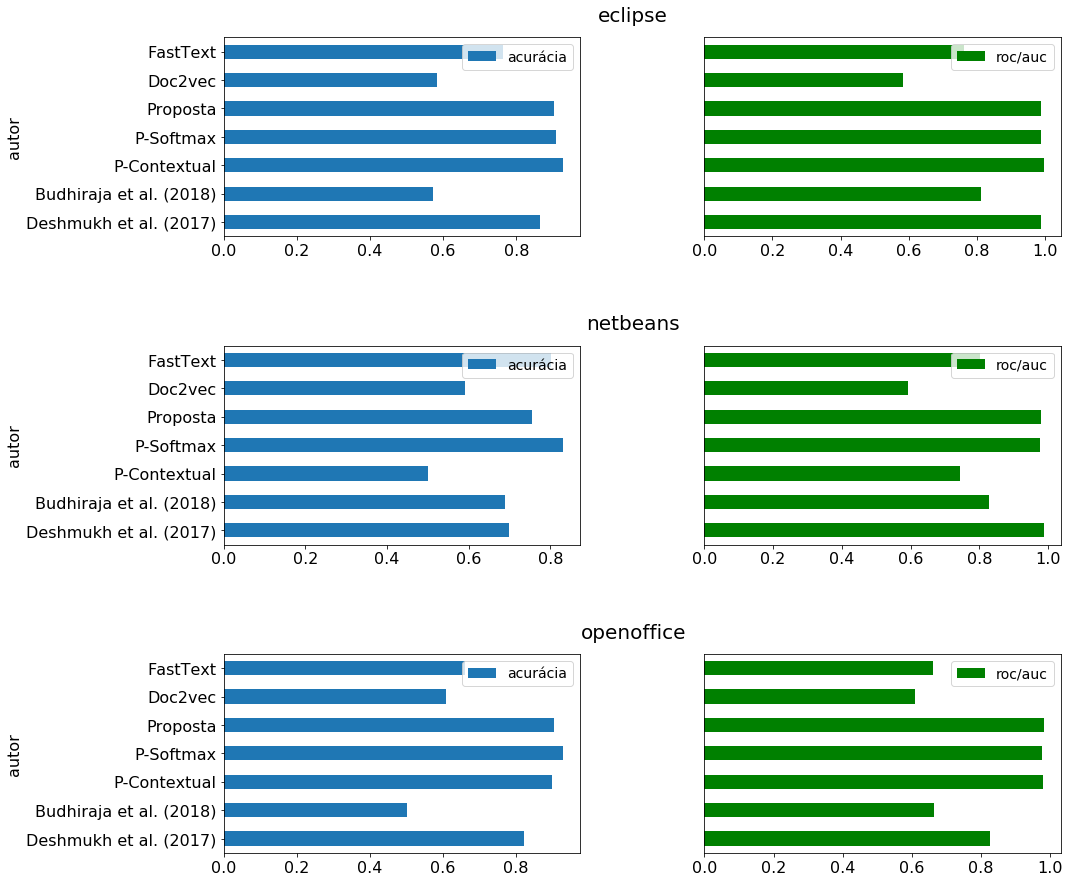

In [10]:
fig, axes = plt.subplots(nrows=len(domains), ncols=2, figsize=(15, 15))

for row, domain in enumerate(domains):
    plt.text(1.15, 1.08, domain,
         horizontalalignment='center',
         fontsize=20,
         transform = axes[row, 0].transAxes)
    ax = df_cls[df_cls['domain'] == domain].set_index('autor')[['acurácia']].plot.barh(ax=axes[row, 0])
    #ax.set_title(domain)
    ax = df_cls[df_cls['domain'] == domain].set_index('autor')[['roc/auc']].plot.barh(ax=axes[row, 1], color='g')
    ax.get_yaxis().set_visible(False)
    #ax.set_title(domain)
    
plt.subplots_adjust(hspace=0.55,
                    wspace=0.35)